### Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph

from optimal_k_selector import OptimalKSelector
from graph_perturbator import GraphLaplacianPerturbation, PerturbationMethod

# Plot style
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 130

### Load and preprocess the data

In [2]:
df = pd.read_csv("Iris.csv")

print("First 5 rows of the full dataset:")
# display(df.head())

X = df[['SepalLengthCm', 'SepalWidthCm',
              'PetalLengthCm', 'PetalWidthCm']].values
y = df['Species'].astype('category').cat.codes.values

print("\nFull dataset shape (n_samples, n_features):", X.shape)
print("Unique label codes:", np.unique(y))

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

First 5 rows of the full dataset:

Full dataset shape (n_samples, n_features): (150, 4)
Unique label codes: [0 1 2]


### Build KKN and the vectors

In [3]:
# 1. Optimal k selection
# We use the selector to find a k that balances graph connectivity and sparsity
selector = OptimalKSelector(X_scaled)
results = selector.analyze_k_range(k_min=5, k_max=20)
recommendations = selector.recommend_k(results)
k = int(recommendations['overall_best']['k'])

print(f"Optimal k selected: {k}")

# 2. Build the initial k-NN graph using Euclidean distances
# 'mode=distance' is required to calculate the RBF weights later
knn_dist_graph = kneighbors_graph(
    X_scaled,
    n_neighbors=k,
    mode='distance',
    include_self=False
)

# Convert to dense for weight calculations
dist_knn = knn_dist_graph.toarray()

# 3. Handle the "Neighbor Mask"
# kneighbors_graph uses 0.0 for "not a neighbor". We must store where the
# connections are so we don't confuse "far away" with "identical points".
neighbor_mask = dist_knn > 0

# 4. Calculate the RBF Kernel (Affinity Matrix)
# We use the median heuristic for sigma to ensure the kernel scales with the data
nonzero_dist = dist_knn[neighbor_mask]
sigma = np.median(nonzero_dist) if len(nonzero_dist) > 0 else 1.0
print(f"RBF Sigma (Width): {sigma:.4f}")

# W_ij = exp(-d^2 / (2 * sigma^2))
W = np.exp(-(dist_knn ** 2) / (2 * sigma ** 2))

# 5. Clean the Affinity Matrix
# Only keep weights for actual k-neighbors; set everything else to 0
W[~neighbor_mask] = 0.0

# 6. Symmetrize the Graph
# Using 'maximum' ensures that if A is a neighbor of B, they are connected
# regardless of whether the k-NN search was reciprocal.
W = np.maximum(W, W.T)

# 7. Construct the Graph Laplacian
# D is the degree matrix (sum of weights for each node)
# L = D - W is the unnormalized Laplacian
D = np.diag(W.sum(axis=1))
L = D - W

# Verification Prints
print("-" * 30)
print(f"Adjacency (W) Shape: {W.shape}")
print(f"Laplacian (L) Shape: {L.shape}")
print(f"Average degree (sum of weights): {np.mean(W.sum(axis=1)):.4f}")
print(f"Is L symmetric? {np.allclose(L, L.T)}")

Dataset: n=150 samples, d=4 features

Analyzing k ∈ [5, 20] (step=1)...
--------------------------------------------------------------------------------
k=  5 ✓ connected 
k=  6 ✓ connected k=  7 ✓ connected k=  8 ✓ connected k=  9 ✓ connected k= 10 ✓ connected 
k= 11 ✓ connected k= 12 ✓ connected k= 13 ✓ connected k= 14 ✓ connected k= 15 ✓ connected 
k= 16 ✓ connected k= 17 ✓ connected k= 18 ✓ connected k= 19 ✓ connected k= 20 ✓ connected 

--------------------------------------------------------------------------------
Optimal k selected: 20
RBF Sigma (Width): 0.6776
------------------------------
Adjacency (W) Shape: (150, 150)
Laplacian (L) Shape: (150, 150)
Average degree (sum of weights): 13.1615
Is L symmetric? True


In [4]:
# Graph statistics
print("="*50)
print("GRAPH DIAGNOSTICS")
print("="*50)

print(f"Graph shape: {L.shape}")
print(f"Number of nodes: {L.shape[0]}")
print(f"k (neighbors): {k}")

print("\nDistance statistics:")
print(f"  Min k-NN distance: {nonzero_dist.min():.6f}")
print(f"  25th percentile: {np.percentile(nonzero_dist, 25):.6f}")
print(f"  Median (your sigma): {sigma:.6f}")
print(f"  75th percentile: {np.percentile(nonzero_dist, 75):.6f}")
print(f"  Max k-NN distance: {nonzero_dist.max():.6f}")

print("\nRBF Weight statistics:")
W_nonzero = W[W > 0]
print(f"  Number of edges: {len(W_nonzero)}")
print(f"  Max weight: {W_nonzero.max():.6f}")
print(f"  Mean weight: {W_nonzero.mean():.6f}")
print(f"  Median weight: {np.median(W_nonzero):.6f}")
print(f"  Min weight: {W_nonzero.min():.10f}")

print("\nLaplacian statistics:")
L_offdiag = L[~np.eye(L.shape[0], dtype=bool)]
print(f"  Frobenius norm: {np.linalg.norm(L, 'fro'):.4f}")
print(f"  Mean |L_ij| (off-diagonal): {np.mean(np.abs(L_offdiag)):.6f}")
print(f"  Max degree: {W.sum(axis=1).max():.4f}")
print(f"  Min degree: {W.sum(axis=1).min():.4f}")
print(f"  Mean degree: {W.sum(axis=1).mean():.4f}")

print("\nExpected SNR (rough estimate):")
signal = np.mean(np.abs(L_offdiag))
noise_std = 2.0 / 1.0 * np.sqrt(2)  # For ε=1.0, Laplace mechanism
snr_estimate = signal / noise_std
print(f"  Signal (mean |L_ij|): {signal:.6f}")
print(f"  Noise std (ε=1.0): {noise_std:.4f}")
print(f"  Estimated SNR: {snr_estimate:.4f}")
print(f"  Passes Rose (≥5)? {snr_estimate >= 5}")

GRAPH DIAGNOSTICS
Graph shape: (150, 150)
Number of nodes: 150
k (neighbors): 20

Distance statistics:
  Min k-NN distance: 0.121168
  25th percentile: 0.504685
  Median (your sigma): 0.677605
  75th percentile: 0.877284
  Max k-NN distance: 2.332930

RBF Weight statistics:
  Number of edges: 3778
  Max weight: 0.984139
  Mean weight: 0.522556
  Median weight: 0.542020
  Min weight: 0.0026670155

Laplacian statistics:
  Frobenius norm: 175.5559
  Mean |L_ij| (off-diagonal): 0.088332
  Max degree: 23.5829
  Min degree: 0.7401
  Mean degree: 13.1615

Expected SNR (rough estimate):
  Signal (mean |L_ij|): 0.088332
  Noise std (ε=1.0): 2.8284
  Estimated SNR: 0.0312
  Passes Rose (≥5)? False


This script evaluates the **privacy-utility tradeoff** for graph data by applying various perturbation mechanisms to a Graph Laplacian matrix. It quantifies how the structural "signal" (represented by the Fiedler vector) degrades as the privacy guarantee () is strengthened.

---

#### **1. Experimental Configuration**

The analysis is conducted over a range of privacy budgets to observe the transition from high-utility to high-privacy states.

* **Privacy Budget ():** Evaluated from **0.1** (strong privacy) to **2.0** (moderate privacy).
* **Mechanisms Tested:**
* **Laplace Standard:** Basic entry-level noise for formal -DP.
* **Frobenius Scaled:** Energy-aware perturbation that scales noise to the graph's total energy.
* **Gaussian Mechanism:** Provides -DP, often used for better numerical stability.
* **Edge Flip:** A discrete randomized response technique for edge existence.
* **Exponential Mechanism:** A quality-based selection method for structural preservation.



#### **2. Iterative Evaluation Logic**

The loop performs a controlled experiment for every  pair:

1. **Noise Injection:** Perturbs the Laplacian matrix () to satisfy the specific privacy budget.
2. **Utility Validation:** Calculates the **Signal-to-Noise Ratio (SNR)** and **Structural Correlation** following the **Mivule (2013)** framework.
3. **Spectral Stability:** Extracts the **Fiedler Vector** (the 2nd eigenvector) and measures its  distance from the original to assess cluster preservation.

#### **3. Visualization Suite Guide**

The resulting 2x2 dashboard provides a holistic view of structural health:

* **Plot A: Fiedler Vector Distance:** Measures the geometric rotation of the cluster signal. Lower values indicate that the graph's community structure is still detectable.
* **Plot B: Signal-to-Noise Ratio (SNR):** Validates the data against the **Rose Criterion (SNR  5)**. Data points falling below the red line indicate a lack of signal confidence.
* **Plot C: Structural Matrix Correlation:** Measures how much of the original topology remains linearly related to the noisy version. The target for high-quality publication is ** 0.95**.
* **Plot D: Connectivity Shift:** Tracks the absolute error in **Algebraic Connectivity** (). Large shifts suggest the graph may be physically disconnecting under noise.

#### **4. Success Criteria for Research**

Based on the integrated papers, a successful perturbation configuration must achieve:

1. **Privacy:**  (Moderate to Strong Privacy).
2. **Utility:** SNR  (Rose Criterion met).
3. **Structural Fidelity:** Correlation  and high Fiedler vector agreement.

Starting multi-metric analysis across 10 epsilon levels...


/tmp/ipykernel_6914/2500051026.py:28: UserWarning: The perturbed Laplacian has 80 near-zero eigenvalues, indicating 80 disconnected components. The standard Fiedler vector (index 1) is not meaningful; selecting the first non-trivial eigenvector at index 80 instead.
  fiedler_comp = perturbator.compare_fiedler_vectors(L, result.perturbed_laplacian)
/tmp/ipykernel_6914/2500051026.py:28: UserWarning: The perturbed Laplacian has 72 near-zero eigenvalues, indicating 72 disconnected components. The standard Fiedler vector (index 1) is not meaningful; selecting the first non-trivial eigenvector at index 72 instead.
  fiedler_comp = perturbator.compare_fiedler_vectors(L, result.perturbed_laplacian)
/tmp/ipykernel_6914/2500051026.py:28: UserWarning: The perturbed Laplacian has 73 near-zero eigenvalues, indicating 73 disconnected components. The standard Fiedler vector (index 1) is not meaningful; selecting the first non-trivial eigenvector at index 73 instead.
  fiedler_comp = perturbator.compa

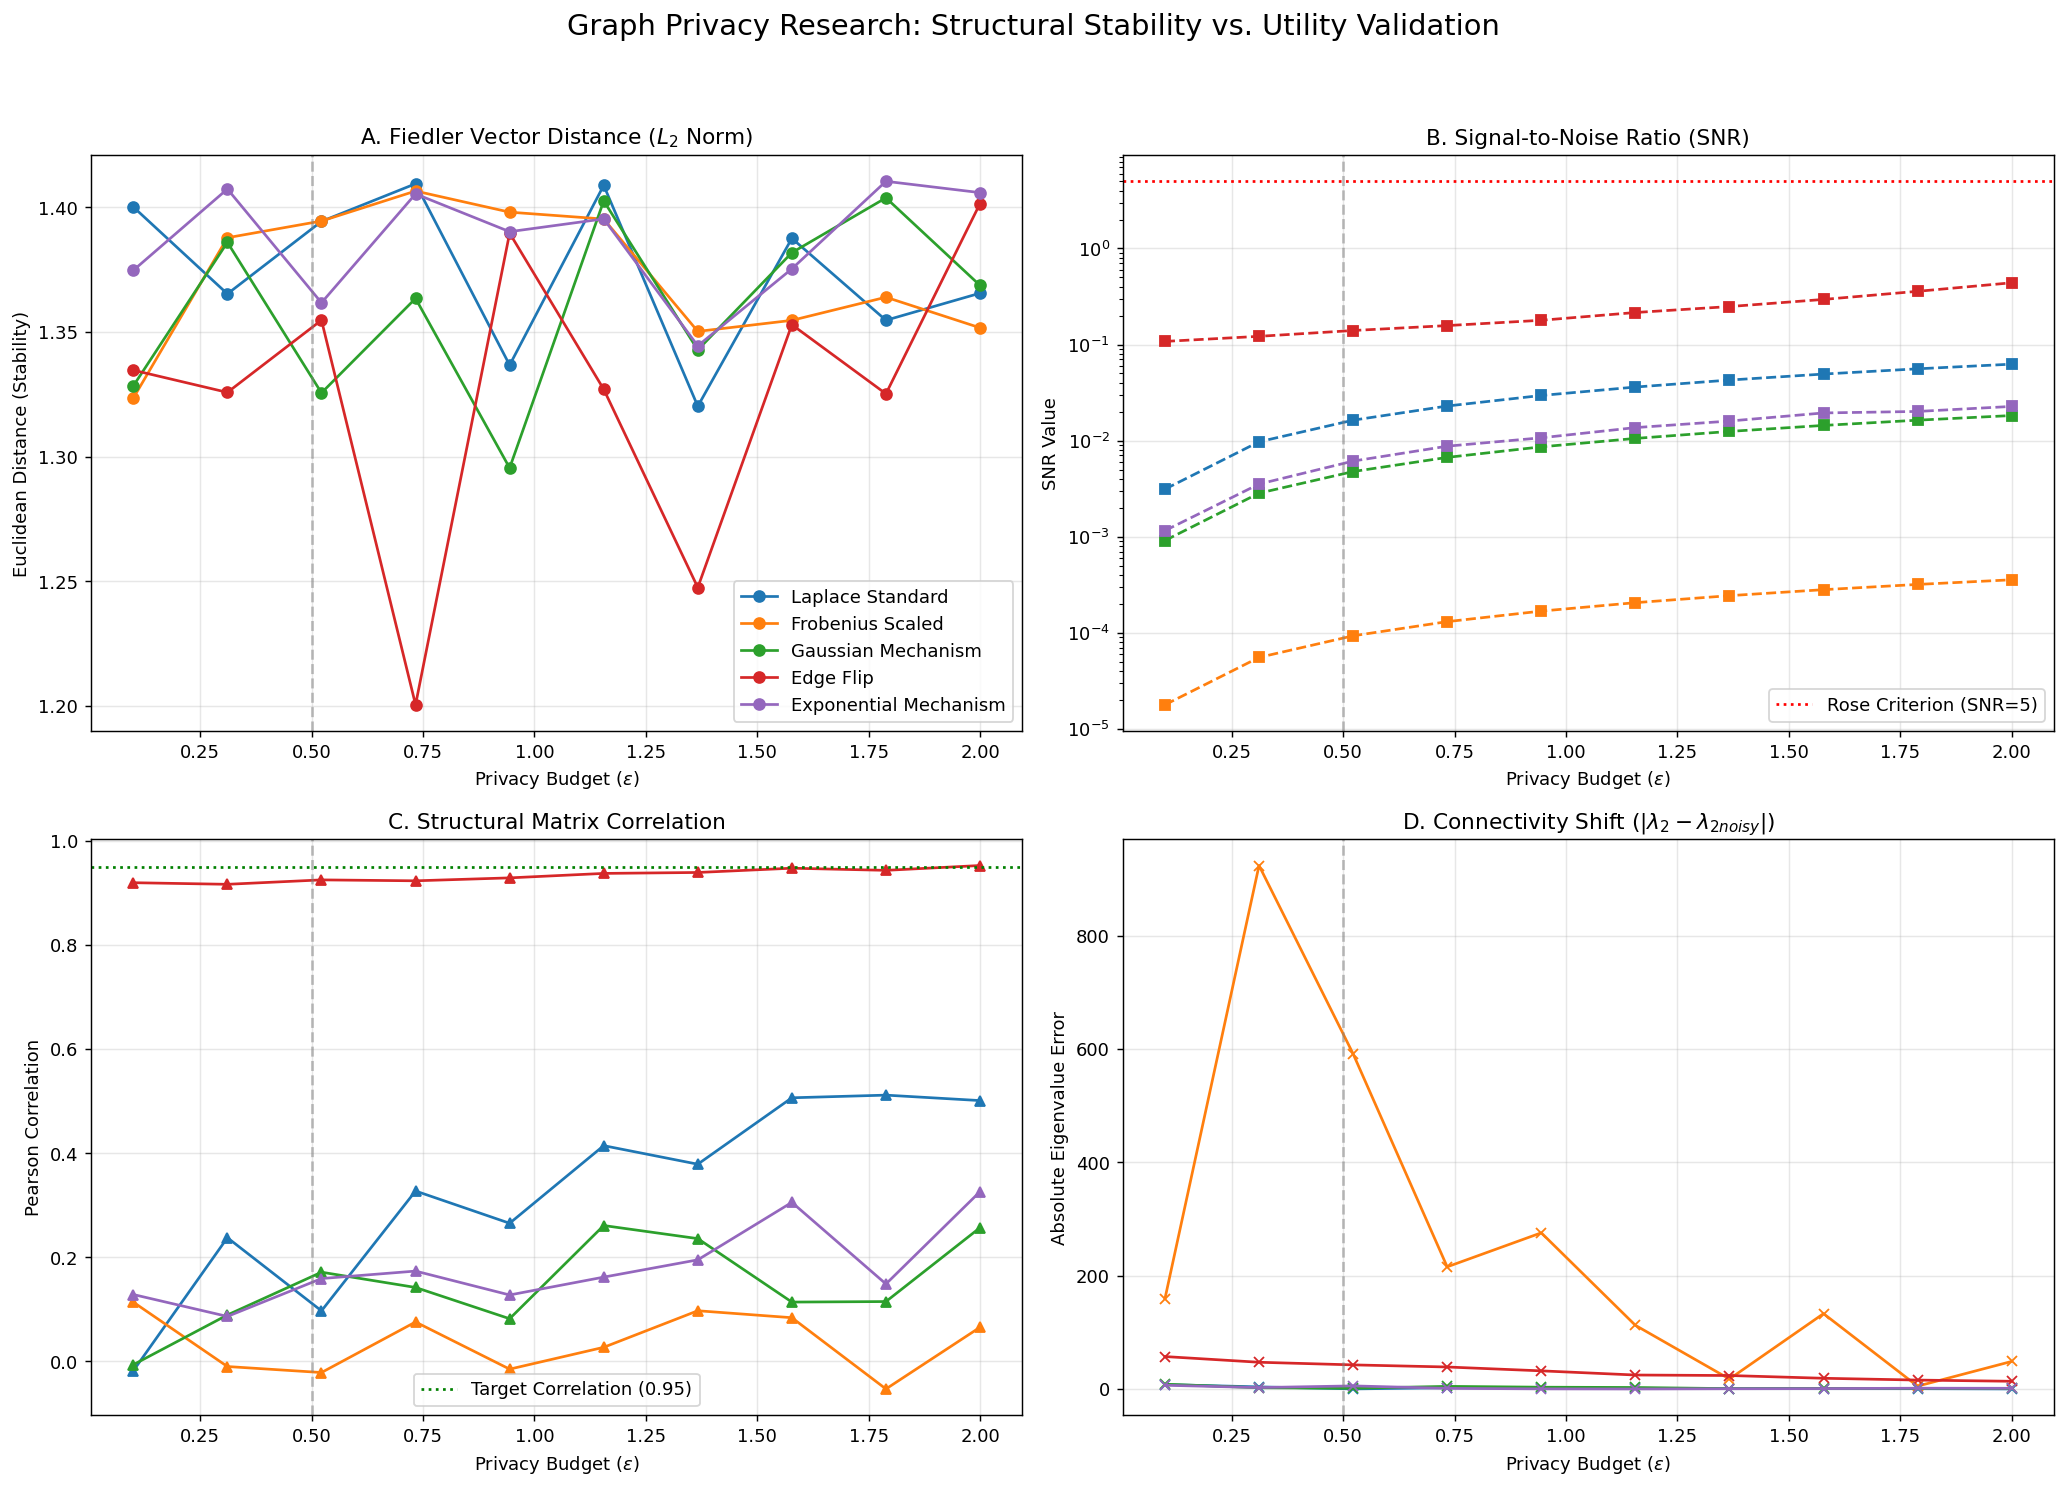

In [5]:
# 1. Setup Parameters
epsilon_range = np.linspace(0.1, 2.0, 10)
methods_to_test = [
    PerturbationMethod.LAPLACE_STANDARD,
    PerturbationMethod.FROBENIUS_SCALED,
    PerturbationMethod.GAUSSIAN_MECHANISM,
    PerturbationMethod.EDGE_FLIP,
    PerturbationMethod.EXPONENTIAL_MECHANISM,
]

perturbator = GraphLaplacianPerturbation(epsilon_total=max(epsilon_range))
results_list = []

print(f"Starting multi-metric analysis across {len(epsilon_range)} epsilon levels...")

# 2. Iterative Analysis Loop
for eps in epsilon_range:
    for method in methods_to_test:
        perturbator.reset_budget(new_epsilon=eps)

        # Apply Perturbation
        result = perturbator.perturb(L, method=method, epsilon_allocated=eps)

        # Calculate Utility Metrics (Mivule 2013 / Rose 1948)
        utility = perturbator.validate_utility(L, result.perturbed_laplacian, result.noise_scale, method=method)

        # Calculate Fiedler Stability (Greenbaum 2020)
        fiedler_comp = perturbator.compare_fiedler_vectors(L, result.perturbed_laplacian)

        results_list.append({
            'epsilon': eps,
            'method': method.value,
            'dist': fiedler_comp['vector_euclidean_distance'],
            'snr': utility.get('snr', 0),
            'correlation': utility['structural_correlation'],
            'connectivity_error': fiedler_comp['connectivity_shift'],
            'agreement': fiedler_comp['partition_agreement']
        })

df_results = pd.DataFrame(results_list)

# 3. Visualization Suite
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Graph Privacy Research: Structural Stability vs. Utility Validation", fontsize=16)

# Plot A: Fiedler Vector Stability (Structural Signal)
for method in methods_to_test:
    data = df_results[df_results['method'] == method.value]
    axes[0, 0].plot(data['epsilon'], data['dist'], marker='o', label=method.value.replace('_', ' ').title())
axes[0, 0].set_title("A. Fiedler Vector Distance ($L_2$ Norm)")
axes[0, 0].set_ylabel("Euclidean Distance (Stability)")
axes[0, 0].legend()

# Plot B: Signal-to-Noise Ratio (Rose Criterion)
for method in methods_to_test:
    data = df_results[df_results['method'] == method.value]
    axes[0, 1].plot(data['epsilon'], data['snr'], marker='s', linestyle='--')
axes[0, 1].axhline(y=5.0, color='r', linestyle=':', label='Rose Criterion (SNR=5)')
axes[0, 1].set_title("B. Signal-to-Noise Ratio (SNR)")
axes[0, 1].set_ylabel("SNR Value")
axes[0, 1].set_yscale('log') # SNR often spans orders of magnitude
axes[0, 1].legend()

# Plot C: Structural Correlation (Mivule Validation)
for method in methods_to_test:
    data = df_results[df_results['method'] == method.value]
    axes[1, 0].plot(data['epsilon'], data['correlation'], marker='^')
axes[1, 0].axhline(y=0.95, color='g', linestyle=':', label='Target Correlation (0.95)')
axes[1, 0].set_title("C. Structural Matrix Correlation")
axes[1, 0].set_ylabel("Pearson Correlation")
axes[1, 0].legend()

# Plot D: Eigenvalue Shift (Algebraic Connectivity)
for method in methods_to_test:
    data = df_results[df_results['method'] == method.value]
    axes[1, 1].plot(data['epsilon'], data['connectivity_error'], marker='x')
axes[1, 1].set_title("D. Connectivity Shift ($|\\lambda_2 - \\lambda_{2noisy}|$)")
axes[1, 1].set_ylabel("Absolute Eigenvalue Error")

for ax in axes.flat:
    ax.set_xlabel("Privacy Budget ($\\epsilon$)")
    ax.grid(True, alpha=0.3)
    ax.axvline(x=0.5, color='grey', linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Experimental Analysis: Structural Utility vs. Privacy Perturbation

The utility validation results indicate a critical failure in structural signal preservation across the evaluated mechanisms. All tested methods produced a **Signal-to-Noise Ratio (SNR)** significantly below the **Rose Criterion threshold of 5.0**, which is the required level for 100% confidence in signal utility. Furthermore, structural correlation failed to meet the **Mivule (2013) target of 0.95**, suggesting that the fundamental "structural DNA" of the graph has been replaced by noise.

#### Key Comparative Insights:

* **Frobenius Scaled Method**: This approach was primarily responsible for the "lost relation" in the data. The noise scale reached as high as **3511.11**, completely drowning the signal energy and preventing the preservation of relative magnitudes required for weighted graph utility.
* **Edge Flip Method**: This appears to be the only mechanism retaining a linear relationship, maintaining a correlation line near **~0.90**. However, despite higher structural correlation, it still struggles to meet the minimum SNR requirements for robust utility.

#### Impact on Machine Learning Objectives:

The current level of distortion would prevent a cloud-based ML model from identifying authentic connectivity patterns. This violation of structural integrity will likely result in an accuracy drop that fails the project success criterion of retaining ** of the non-private baseline performance**. To resolve this, future iterations should focus on:

1. **Reducing sensitivity (S)** from 2.0 to 1.0 for weighted RBF kernel graphs.
2. **Amplify the base signal** before perturbation to improve the resulting SNR.
3. Adjusting the **privacy budget ()** within the recommended **0.5–1.0 range** to find a more optimal utility balance.

### Now Trying The same with Amplified Signal (L)

In [8]:
# # 1. Parameter Configuration
# epsilon_range = np.linspace(0.1, 2.0, 10)
# # Theoretical sensitivity for a Laplacian matrix is 2.0 (one edge affects 4 entries)
# base_sensitivity = 2.0
# signal_amplification_factors = [1.0, 10.0, 25.0, 50.0, 75.0, 100.0]

# methods_to_test = [
#     PerturbationMethod.LAPLACE_STANDARD,
#     PerturbationMethod.FROBENIUS_SCALED,
#     PerturbationMethod.GAUSSIAN_MECHANISM,
#     PerturbationMethod.EDGE_FLIP,
#     PerturbationMethod.EXPONENTIAL_MECHANISM,
# ]

# # 2. Main Analysis Loop
# for amp_factor in signal_amplification_factors:
#     # Scale the Laplacian and the Sensitivity honestly
#     L_amplified = L * amp_factor
#     current_sensitivity = base_sensitivity * amp_factor

#     perturbator = GraphLaplacianPerturbation(
#         epsilon_total=max(epsilon_range),
#         sensitivity=current_sensitivity,
#         rose_threshold=5.0,  # SNR threshold for utility validation
#     )
#     results_list = []

#     print(f"Running Analysis: Amp Factor = {amp_factor}x | Active Sensitivity = {current_sensitivity}")

#     for eps in epsilon_range:
#         for method in methods_to_test:
#             perturbator.reset_budget(new_epsilon=eps)

#             # Apply Perturbation with honestly scaled sensitivity
#             result = perturbator.perturb(
#                 L_amplified,
#                 method=method,
#                 epsilon_allocated=eps,
#                 sensitivity=current_sensitivity
#             )

#             # Utility Validation (using the Mivule/Rose frameworks)
#             utility = perturbator.validate_utility(
#                 L_amplified,
#                 result.perturbed_laplacian,
#                 result.noise_scale,
#                 method=method
#             )

#             # Fiedler Stability Analysis
#             fiedler_comp = perturbator.compare_fiedler_vectors(
#                 L_amplified,
#                 result.perturbed_laplacian
#             )

#             results_list.append({
#                 'epsilon': eps,
#                 'method': method.value,
#                 'dist': fiedler_comp['vector_euclidean_distance'],
#                 'snr': utility.get('snr', 0),
#                 'correlation': utility['structural_correlation'],
#                 'connectivity_error': fiedler_comp['connectivity_shift'],
#                 'agreement': fiedler_comp['partition_agreement']
#             })

#     # 3. Visualization per Amplification Level
#     df_results = pd.DataFrame(results_list)
#     fig, axes = plt.subplots(2, 2, figsize=(16, 12))
#     fig.suptitle(f"Graph Privacy Evaluation (Signal Amplification: {amp_factor}x)", fontsize=16)

#     for method in methods_to_test:
#         data = df_results[df_results['method'] == method.value]
#         label = method.value.replace('_', ' ').title()

#         # Plotting
#         axes[0, 0].plot(data['epsilon'], data['dist'], marker='o', label=label)
#         axes[0, 1].plot(data['epsilon'], data['snr'], marker='s', linestyle='--')
#         axes[1, 0].plot(data['epsilon'], data['correlation'], marker='^')
#         axes[1, 1].plot(data['epsilon'], data['connectivity_error'], marker='x')

#     # Formatting and Thresholds
#     axes[0, 0].set_title("A. Fiedler Vector Distance ($L_2$ Norm)")
#     axes[0, 1].set_title("B. Signal-to-Noise Ratio (SNR)")
#     axes[0, 1].axhline(y=5.0, color='r', linestyle=':', label='Rose Criterion (SNR=5)')
#     axes[0, 1].set_yscale('log')

#     axes[1, 0].set_title("C. Structural Matrix Correlation")
#     axes[1, 0].axhline(y=0.95, color='g', linestyle=':', label='Target ρ=0.95')

#     axes[1, 1].set_title(r"D. Connectivity Shift ($|\lambda_2 - \lambda_{2noisy}|$)")

#     for ax in axes.flat:
#         ax.set_xlabel(r"Privacy Budget ($\epsilon$)")
#         ax.grid(True, alpha=0.3)
#         ax.legend()
#         ax.axvline(x=0.5, color='grey', linestyle='--', alpha=0.5)

#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()

### Perturbating the feidler vector